In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
from datetime import date , datetime
from copy import deepcopy
from random import randint,sample
import math
np.random.seed(123)

In [2]:
tickers = ['AXP','AMGN','AAPL','BA','CAT','CSCO',
          'CVX','GS','HD','HON','IBM','INTC',
          'JNJ','KO','JPM','MCD','MMM','MRK',
          'MSFT','NKE','PG','TRV','UNH','CRM',
          'VZ','V','WBA','WMT','DIS']
# closes = pd.DataFrame()
# for ticker in tickers:
#     data = yf.download(ticker,start="2010-01-01", end="2022-12-31")['Adj Close']
#     closes[ticker] = data

In [3]:
closes = pd.read_csv('closes.csv')
closes = closes.set_index('Date')
closes.index = pd.to_datetime(closes.index)
closes

,AXP,AMGN,AAPL,BA,CAT,CSCO,CVX,GS,HD,HON,...,NKE,PG,TRV,UNH,CRM,VZ,V,WBA,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,33.675972,43.267185,6.515212,43.777554,41.353188,17.394129,47.266056,140.864227,21.122950,28.948059,...,13.989440,41.439655,36.311012,25.983183,18.705000,16.568348,20.094746,26.326159,40.329697,27.933922
2010-01-05,33.601902,42.892368,6.526476,45.211346,41.847595,17.316628,47.600853,143.354767,21.277676,29.005459,...,14.045097,41.453205,35.450813,25.941975,18.625000,16.598211,19.864477,26.114433,39.928089,27.864239
2010-01-06,34.145073,42.570061,6.422663,46.582798,41.974720,17.203917,47.606823,141.824661,21.204000,29.005459,...,13.959471,41.256588,34.947811,26.197437,18.592501,16.120949,19.597736,25.916807,39.838867,27.716164
2010-01-07,34.698856,42.180260,6.410790,48.468563,42.144226,17.281410,47.427479,144.599915,21.454493,29.565037,...,14.096473,41.032837,35.450813,27.202810,18.510000,16.024992,19.780119,26.072079,39.861164,27.724873
2010-01-08,34.674061,42.555058,6.453412,48.001011,42.617443,17.372992,47.511169,141.865372,21.351341,30.217890,...,14.068647,40.978607,35.399765,26.947342,18.537500,16.035097,19.834841,26.107365,39.660381,27.768425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,146.512161,263.920013,131.860001,189.059998,239.869995,47.103645,177.399994,345.510010,318.730011,213.869995,...,116.250000,152.619995,189.479996,531.309998,129.440002,37.815506,205.830002,38.630001,143.770004,88.010002
2022-12-27,145.884338,263.390015,130.029999,189.399994,243.139999,47.153248,179.630005,341.970001,319.549988,214.889999,...,117.559998,153.949997,190.479996,531.989990,130.660004,38.642506,206.289993,38.310001,143.809998,86.370003
2022-12-28,143.512558,261.420013,126.040001,188.380005,239.380005,46.696896,176.979996,340.869995,315.730011,212.190002,...,114.980003,151.960007,188.130005,528.450012,128.470001,38.209316,204.990005,37.580002,141.289993,84.169998


In [4]:
def max_drawdown(equity_curve):
    maximum_equity = 0
    maximum_drawdown = 0
    for daily_equity in equity_curve:
        maximum_equity = max(maximum_equity,daily_equity)
        drawdown = (daily_equity-maximum_equity)/maximum_equity
        maximum_drawdown = min(drawdown,maximum_drawdown)
    return maximum_drawdown
def sharpe_ratio(equity_curve, risk_free_rate=0.0):
    daily_changes=np.diff(equity_curve) / equity_curve[1:]
    mean_daily_return = sum(daily_changes) / len(daily_changes)
    s = np.std(daily_changes)
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    return sharpe_ratio

In [5]:
class BackTest:
    def __init__(self,capital=10_000):
        self.capital = capital
        self.available_capital = capital
        self.equity_curve = np.array([self.capital])
        self.total_return = 0
        self.max_drawdown = {}
        self.sharpe = {}
        self.std = {}
        self.num_stocks = {}
        
    def run(self, dates :tuple, weights: dict):
        date_filtered = None
        for stock, weight in weights.items():
            share_of_capital = self.available_capital * weight 
            date_filtered = closes[np.logical_and(closes.index >= datetime(dates[0], 1, 1) , closes.index <= datetime(dates[1], 12, 31))]
            stock_closes = date_filtered[stock]
            stock_size = math.floor(share_of_capital / stock_closes.values[0])
            self.num_stocks[stock] = stock_size
        for index,row in date_filtered.iterrows():
            daily_equity = 0
            for stock in self.num_stocks.keys():
                daily_equity += self.num_stocks[stock]*date_filtered.loc[index][stock]
            self.equity_curve = np.append(self.equity_curve,daily_equity)
        changes=np.diff(self.equity_curve) / self.equity_curve[1:]
        self.max_drawdown = max_drawdown(self.equity_curve)
        self.sharpe = sharpe_ratio(self.equity_curve)
        self.std = np.std(changes*100)
        self.total_return = (self.equity_curve[-1] - self.equity_curve[0]) / self.equity_curve[0]
        return {'equity_curve':self.equity_curve ,  
                'total_return':self.total_return,
                'sharpe_ratio':self.sharpe,
                'max_drawdown':self.max_drawdown,
                'std':self.std}
        

In [6]:
b = BackTest()
stats = b.run((2010,2020),{'AAPL':0.5,'CSCO':0.5})

In [7]:
stats

{'equity_curve': array([ 10000.        ,   9989.28261471,   9975.67947912, ...,
        114190.48474503, 113275.99204636, 112567.75814056]),
 'total_return': 10.256775814056397,
 'sharpe_ratio': 0.7402222884544782,
 'max_drawdown': -0.33476777053347684,
 'std': 1.6005793272400368}

Text(0, 0.5, 'Equity')

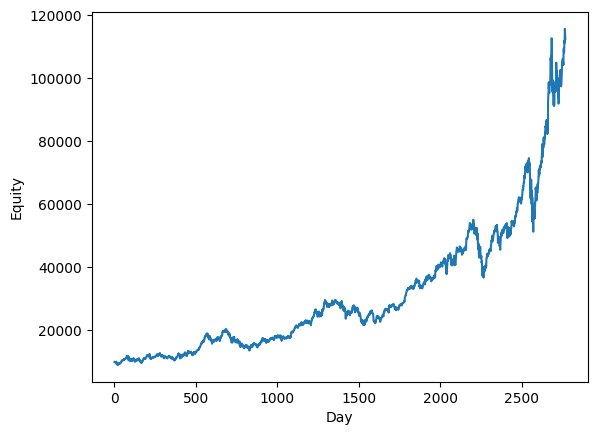

In [8]:
plt.plot(stats['equity_curve'])
plt.xlabel('Day')
plt.ylabel('Equity')

# Optimize Last Years Least Correlated 5 Stocks

In [9]:
years = np.arange(2010,2023)
num_stocks = 5
for year in years:
    date_filtered = closes[np.logical_and(closes.index >= datetime(year, 1, 1) , closes.index <= datetime(year, 12, 31))]
    correlations = date_filtered.corr().stack().sort_values()
    least_correlated = []
    for index,value in correlations.items():
        for ticker in index:
            if ticker not in least_correlated:
                least_correlated.append(ticker)
            if len(least_correlated) >= num_stocks:
                break
    least_correlated = least_correlated[:num_stocks]
    print(f'year: {year}, least correlated {num_stocks} stocks: {least_correlated}')

year: 2010, least correlated 5 stocks: ['CSCO', 'CRM', 'KO', 'VZ', 'V']
year: 2011, least correlated 5 stocks: ['MCD', 'GS', 'V', 'JPM', 'WBA']
year: 2012, least correlated 5 stocks: ['VZ', 'CAT', 'INTC', 'TRV', 'WMT']
year: 2013, least correlated 5 stocks: ['IBM', 'AAPL', 'BA', 'NKE', 'CAT']
year: 2014, least correlated 5 stocks: ['V', 'IBM', 'NKE', 'AMGN', 'PG']
year: 2015, least correlated 5 stocks: ['NKE', 'WMT', 'V', 'CRM', 'AXP']
year: 2016, least correlated 5 stocks: ['JPM', 'NKE', 'UNH', 'CAT', 'CVX']
year: 2017, least correlated 5 stocks: ['AXP', 'WBA', 'CAT', 'MSFT', 'IBM']
year: 2018, least correlated 5 stocks: ['MRK', 'GS', 'WMT', 'INTC', 'IBM']
year: 2019, least correlated 5 stocks: ['TRV', 'WBA', 'KO', 'MMM', 'MCD']
year: 2020, least correlated 5 stocks: ['WMT', 'WBA', 'MSFT', 'INTC', 'AAPL']
year: 2021, least correlated 5 stocks: ['DIS', 'HD', 'AMGN', 'CRM', 'PG']
year: 2022, least correlated 5 stocks: ['MRK', 'CRM', 'DIS', 'INTC', 'VZ']


In [10]:
class Chromosome:
    def __init__(self,stocks,genes):
        self.stocks = stocks
        self.genes = genes
    def fitness(self):
        s = {}
        for i,stock in enumerate(self.stocks):
            s[stock] = self.genes[i].weight
        a=BackTest()
        stats = a.run(dates = (2015,2021),weights=s)
        return [stats['sharpe_ratio'],stats['std'],stats['total_return']]
    def __str__(self):
        return f"{self.stocks} {[str(i) for i in self.genes]}"
    def set_weights_index(self,index_,weight):
        self.genes[index_].weight = weight
    def get_weights(self):
        return [i.weight for i in self.genes]
    def set_weights(self,weights):
        for i,weight in enumerate(weights):
            self.genes[i].weight = weight

In [11]:
class Gene:
    def __init__(self,weight):
        self.weight = weight
    def __str__(self):
        return f"{self.weight}"

In [12]:
#least correlated stocks of year 2014
stocks = ['V', 'IBM', 'NKE', 'AMGN', 'PG']

In [13]:
# initial population with random weights
initial_pop = 10
pop = []
for i in range(initial_pop):
    genes = []
    weights = np.array(np.random.random(5))
    weights = weights/np.sum(weights)
    for weight in weights:
        genes.append(Gene(weight))
    pop.append(Chromosome(stocks,genes))

In [14]:
def roulette_wheel_selection(p):
    c = np.cumsum(p)
    r = sum(p) * np.random.rand()
    ind = np.argwhere(r <= c)
    return ind[0][0]

In [15]:
def crossover(p1, p2):
    c1 = deepcopy(p1)
    c2 = deepcopy(p2)
    for i in range(len(c1.genes)):
        prob = np.random.uniform(0, 1, 1)
        if prob < 0.5:
            c1.set_weights_index(i,p2.get_weights()[i]) 
        else:
            c2.set_weights_index(i,p1.get_weights()[i]) 
    c1.set_weights(c1.get_weights()/np.sum(c1.get_weights())) 
    c2.set_weights(c2.get_weights()/np.sum(c2.get_weights())) 
    return c1, c2
def mutate(c1):
    for i in range(len(c1.genes)):
        prob = np.random.uniform(0, 1, 1)
        if prob < 0.05:
            c1.set_weights_index(i,c1.get_weights()[i] + 0.1) 
    c1.set_weights(c1.get_weights()/np.sum(c1.get_weights())) 
    return c1

In [16]:
#best sharpe of initial population with random weights
iterations = 300
best_sharpe = 0
scores = [i.fitness()[0] for i in pop]
all_sharpes = []
all_stds = []
all_returns = []
print(f'Best Sharpe: {max(scores)}')

Best Sharpe: 0.6370748599049206


In [17]:
#this takes some time
for i in range(iterations):
    best_sharpe = max(scores)
    print(f'iteration: {i} , best_sharpe: {best_sharpe}')
    beta = 1
    scores = np.array(scores)
    avg_cost = np.mean(scores)
    if avg_cost != 0:
        a = scores/avg_cost
    probs = np.exp(beta*a)
# select chromosomes for crossover
    p1 = pop[roulette_wheel_selection(probs)]
    p2 = pop[roulette_wheel_selection(probs)]
    c1,c2 = crossover(p1,p2)
# mutate
    c1 = mutate(c1)
    c2 = mutate(c2)
    fitness1 = c1.fitness()
    fitness2 = c2.fitness()
    f1 = fitness1[0]
    f2 = fitness2[0]
    all_sharpes.append(f1)
    all_sharpes.append(f2)
    all_stds.append(fitness1[1])
    all_stds.append(fitness2[1])
    all_returns.append(fitness1[2])
    all_returns.append(fitness2[2])

#if childs are better, put them in population and delete a random element
    if f1 > best_sharpe:
        index = randint(0, len(pop)-1)
        pop = np.delete(pop, index)
        scores = np.delete(scores, index)
        pop = np.append(pop,c1)
        best_sharpe = f1
        scores=np.append(scores,f1)
    if f2 > best_sharpe:
        index = randint(0, len(pop)-1)
        pop = np.delete(pop, index)
        scores = np.delete(scores, index)
        pop = np.append(pop,c2)
        best_sharpe = f2
        scores=np.append(scores,f2)

iteration: 0 , best_sharpe: 0.6370748599049206
iteration: 1 , best_sharpe: 0.6370748599049206
iteration: 2 , best_sharpe: 0.6370748599049206
iteration: 3 , best_sharpe: 0.6370748599049206
iteration: 4 , best_sharpe: 0.6370748599049206
iteration: 5 , best_sharpe: 0.6370748599049206
iteration: 6 , best_sharpe: 0.6370748599049206
iteration: 7 , best_sharpe: 0.6581188585601239
iteration: 8 , best_sharpe: 0.6581188585601239
iteration: 9 , best_sharpe: 0.6581188585601239
iteration: 10 , best_sharpe: 0.6936359161841429
iteration: 11 , best_sharpe: 0.6936359161841429
iteration: 12 , best_sharpe: 0.6936359161841429
iteration: 13 , best_sharpe: 0.6936359161841429
iteration: 14 , best_sharpe: 0.6936359161841429
iteration: 15 , best_sharpe: 0.6936359161841429
iteration: 16 , best_sharpe: 0.6936359161841429
iteration: 17 , best_sharpe: 0.6936359161841429
iteration: 18 , best_sharpe: 0.6936359161841429
iteration: 19 , best_sharpe: 0.6936359161841429
iteration: 20 , best_sharpe: 0.6936359161841429
it

In [18]:
best_sharpe = max(scores)
print(best_sharpe)
best_chromosome = pop[np.where(scores == best_sharpe)[0][0]]
best_chromosome.get_weights()

0.6991445349065151


[0.21974133322679434,
 0.044515561641432035,
 0.30315756053127807,
 0.041251597138826174,
 0.3913339474616694]

# The best sharpe of initial population was 0.637, after optimization it becomes 0.699